# Trabalho Final - Modelos de IA e Machine Learning

### Integrantes:

###    1) Jurandir Ventura - RM336634
###    2) Marcelo Preto - RM336632
###    3) Fabio Rizzi - RM336656
###    4) Thiago Alexandre – RM336583

# Exercício 5.1

Utilizando o exemplo visto com o SVM e o dataset Titanic faça um GridSearch para encontrar a melhor configuração de parâmetros, entre o tipo de Kernel, pré-processamento (StandardScalar e MinMaxScalar), Gamma e C.

Qual foi a melhor configuração que você encontrou? Qual a melhor acurácia?

Dica: 

- Observe a matriz de confusão para verificar se o classificar está conseguindo classificar dados das duas classes;
- Normalize os dados;

In [1]:
#Importando as bibliotecas. Se houver algum erro, use "pip install Libname"
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
#Leitura do dataset .csv

#Lembrar que a origem da dataset é uma variável.
#Neste caso é proveniente da pasta de datasets do Github: https://github.com/fiapIA/modelos_de_ia_e_ml/data

dataset = pd.read_csv('data/5.1_titanic/train.csv', sep=',', engine='python')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Analisando o tamanho do dataset

dataset.shape

(891, 12)

In [4]:
# Visão geral dos dados (com DataType)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Verificaçõ se tem dados nulos / faltantes

dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Analisando os dados podemos inferir que algumas colunas não agregam poder decisório ao classificador, são as colunas: PassengerId, Name, Ticket e Cabin. Vamos removê-las do nosso dataset.

In [6]:
# Limpando o dataset

titanic_data = dataset.drop(['PassengerId','Name','Ticket','Cabin'], 1)

In [7]:
# Função para ver a idade média de passageiros em cada Classe (1, 2 e 3).
# Assim preencheremos os faltantes com a média (mean)

titanic_data.groupby(['Pclass'])['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [8]:
#Função para preencher idade (Age), pois tem 177 dados faltantes.

def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38 #baseado na média de idade de passageiros dessa classe
        elif Pclass == 2:
            return 29 #baseado na média de idade de passageiros dessa classe
        else:
            return 25 #baseado na média de idade de passageiros dessa classe
    else:
        return Age

titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

In [9]:
# A coluna "Embarked" tem dois registros faltantes. Vamos remover essas duas linhas do dataset.

titanic_data.dropna(inplace=True)
titanic_data.shape

(889, 8)

## Por fim, vamos transformar as colunas do tipo Object em numéricas utilizando a função get_dummies.

In [10]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)

embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)

titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)

titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Análise da correlação:

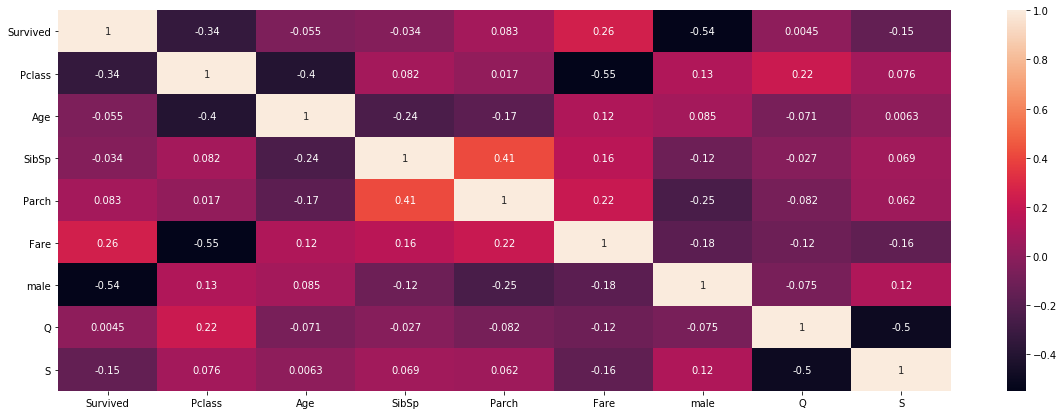

In [11]:
plt.figure(figsize=(20,7))
sb.heatmap(titanic_dmy.corr(), annot = True)

### 'Pclass' e 'Fare' apresentam correlação de -0,55 e 'Q' e 'S' de -0,5. Vamos remover 'Pclass' e 'Q' do nosso dataset. 

In [12]:
titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.drop(['Q'],axis=1,inplace=True)

### Separamos a variável alvo das características

In [13]:
y = titanic_dmy['Survived']
X = titanic_dmy.drop('Survived', axis=1)

### Criamos os pipelines para execução do classificador para cada tipo de Kernel e normalização.

In [14]:
pip_1 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC(kernel='rbf'))
])

pip_2 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='rbf'))
])

pip_3 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='poly'))
])

pip_4 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='linear'))
])

arr_pipelines = [pip_1, pip_2, pip_3, pip_4]

### Executamos o cross-validation de cada um deles e verificamos qual possui a maior acurácia.

In [15]:
indexAux = 0

for pip in arr_pipelines:
    resultados = cross_val_predict(pip, X, y, cv=5)
    indexAux += 1
    print ('pip_', indexAux, ' ==> ', metrics.accuracy_score(y,resultados))

pip_ 1  ==>  0.7930258717660292
pip_ 2  ==>  0.8267716535433071
pip_ 3  ==>  0.7975253093363329
pip_ 4  ==>  0.7862767154105736


### A melhor acurácia foi de 0,826 do kernel RBF com StandardScaler. Próximo passo é utilizarmos o GridSearch para encontrarmos a melhor configuração de parâmetros para esse classificador.

In [16]:
lista_C = [0.001, 0.01, 0.1, 1, 10,100]
lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = dict(clf__C=lista_C, clf__gamma=lista_gamma)

grid = GridSearchCV(pip_2, param_grid, cv=5, scoring='accuracy', verbose = 1)
grid.fit(X, y)

print("Melhor C e Gamma ==> {}".format(grid.best_params_))
print("Melhor Acurácia ==> {}".format(grid.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Melhor C e Gamma ==> {'clf__C': 1, 'clf__gamma': 0.1}
Melhor Acurácia ==> 0.8245540531962166


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.3s finished


### O melhor C é 1 e o melhor gamma 0.1 com acurácia de 0.824. Ou seja, nesse modelo, a acurácia é praticamente a mesma da execução sem o fitting dos parâmetros.

In [17]:
pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='rbf',C=1,gamma=0.1))
])

resultados = cross_val_predict(pip_5, X, y, cv=5)

print("Acurácia: {}".format(metrics.accuracy_score(y,resultados)))
print(metrics.classification_report(y,resultados,target_names=['0','1']))

Acurácia: 0.8245219347581553
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       549
           1       0.80      0.72      0.76       340

    accuracy                           0.82       889
   macro avg       0.82      0.80      0.81       889
weighted avg       0.82      0.82      0.82       889



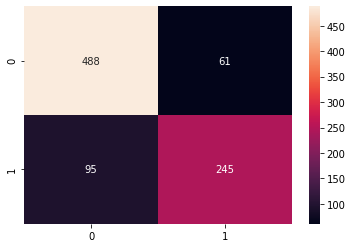

In [18]:
# Matriz de confusão:

sb.heatmap(metrics.confusion_matrix(y, resultados), annot = True, fmt = "d")

## O classificador consegue classificar dados das duas "categorias", quem sobreviveu e quem não sobreviveu.